In [1]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [2]:
training_data = datasets.FashionMNIST(
    root="data", # root is the path where the train/test data is stored
    train=True, # train specifies training or test dataset
    download=True, # download=True downloads the data from the internet if it’s not available at root
    transform=ToTensor() # transform and target_transform specify the feature and label transformations
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [4]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, p):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
def switch_grad_mode(model: nn.Module , requires_grad: bool=True):
    for param in model.parameters():
        param.requires_grad = requires_grad


def switch_model_mode(model: nn.Module, train: bool=True):
    if train:
        model.train()
    else:
        model.eval()

In [24]:
def train_validate(dataloader, model, loss_fn, optimizer, device):
    size_val_batches, number_val_batches = 0, 0
    size_test_batches, number_test_batches = 0,0
    
    l = 0
    val_loss, val_acc = 0, 0
    
    size = len(dataloader.dataset)
    model = model.to(device)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        switch_grad_mode(model, True)
        switch_model_mode(model, True)
        
        if batch % 10 == 0:
            switch_grad_mode(model, False)
            switch_model_mode(model, False)
            pred = model(X)
            size_val_batches += 64
            number_val_batches += 1
            val_loss += loss_fn(pred, y).item() # .item() достает значение из тензора
            val_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            continue
            

        # Вычисляем лосс
        pred = model(X) # делаем проход по функции forward
        loss = loss_fn(pred, y)

        # Теперь весь страшный алгоритм backprop, который был на лекции, скрыт от нас
        optimizer.zero_grad() # перед тем как считать новые градиенты, стираем градиенты с предыдущей итерации обучения
        loss.backward() # считаем градиенты
        optimizer.step() # посчитав градиент, просим оптимизатор обновить аргументы
        
        size_test_batches += 64
        number_test_batches += 1
        l += loss.item()
        if batch % 100 == 99:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    val_loss = val_loss / number_val_batches
    val_acc = val_acc / size_val_batches
    l /= number_test_batches
    
        
    return val_acc, val_loss, l
            
'''           
def validate(dataloader, model, loss_fn, device):
    val_loss, val_acc = 0, 0
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    switch_grad_mode(model, requires_grad=False)
    switch_model_mode(model, train=False)
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        val_loss += loss_fn(pred, y).item() # .item() достает значение из тензора
        val_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    val_acc /= size
    
    return val_acc, val_loss
'''
            
            
def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # переводим модель в режим тестирования
    # если вы используете валидацию, там нужно сделать то же самое
    switch_grad_mode(model, requires_grad=False)
    switch_model_mode(model, train=False)
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item() # .item() достает значение из тензора
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss
    
    
    
    


In [25]:
comparison_param = [0,0]
main_val_acc, main_val_loss, main_losses = [], [], []

for p in [0.2,0.4]:
    val_acc, val_loss = [], []

    epochs = 30
    model = NeuralNetwork(p)
    loss_fn = nn.CrossEntropyLoss() # В качестве лосса возьмем кросс-энтропию
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-3) # возьмем страндартный алгоритм оптимизации - стохастический градиентный спуск
    device = torch.device("cpu")

    accuracy, losses = 0, []


    for t in range(1, epochs + 1):
        print(f"Epoch {t}\n-------------------------------")
        new_acc, new_loss, loss = train_validate(train_dataloader, model, loss_fn, optimizer, device)
        losses.append(loss)
        if len(val_loss) > 0:
            if new_loss > val_loss[-1]:
                break
            else:
                val_acc.append(new_acc)
                val_loss.append(new_loss)
                torch.save(model.state_dict(), 'model_weights.pth')
        val_acc.append(new_acc)
        val_loss.append(new_loss)
        torch.save(model.state_dict(), 'model_weights.pth')

    if comparison_param[0] < val_acc[-1]:
        comparison_param = [val_acc[-1], p]
        torch.save(model.state_dict(), 'main_weights.pth')
        main_val_acc = val_acc.copy()
        main_val_loss = val_loss.copy()
        
        main_losses = losses.copy()


print("Done!")

Epoch 1
-------------------------------
loss: 2.298747  [ 6336/60000]
loss: 2.298163  [12736/60000]
loss: 2.305684  [19136/60000]
loss: 2.296362  [25536/60000]
loss: 2.299314  [31936/60000]
loss: 2.304785  [38336/60000]
loss: 2.303310  [44736/60000]
loss: 2.297314  [51136/60000]
loss: 2.295842  [57536/60000]
Epoch 2
-------------------------------
loss: 2.277024  [ 6336/60000]
loss: 2.284100  [12736/60000]
loss: 2.282563  [19136/60000]
loss: 2.281193  [25536/60000]
loss: 2.270044  [31936/60000]
loss: 2.270012  [38336/60000]
loss: 2.263362  [44736/60000]
loss: 2.256202  [51136/60000]
loss: 2.246915  [57536/60000]
Epoch 3
-------------------------------
loss: 2.230882  [ 6336/60000]
loss: 2.204391  [12736/60000]
loss: 2.193421  [19136/60000]
loss: 2.157662  [25536/60000]
loss: 2.080485  [31936/60000]
loss: 1.969955  [38336/60000]
loss: 1.889098  [44736/60000]
loss: 1.652738  [51136/60000]
loss: 1.558613  [57536/60000]
Epoch 4
-------------------------------
loss: 1.444287  [ 6336/60000]


In [26]:
model = NeuralNetwork(comparison_param[1])
model.load_state_dict(torch.load('main_weights.pth'))
test(train_dataloader, model, loss_fn, device)

'''
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, device)
    test_loss = test(test_dataloader, model, loss_fn, device)
    torch.save(model.state_dict(), 'model_weights.pth')
    main_losses.append(test_loss)
print("Done!")
'''

Test Error: 
 Accuracy: 84.2%, Avg loss: 0.449182 



'\nfor t in range(epochs):\n    print(f"Epoch {t+1}\n-------------------------------")\n    train(train_dataloader, model, loss_fn, optimizer, device)\n    test_loss = test(test_dataloader, model, loss_fn, device)\n    torch.save(model.state_dict(), \'model_weights.pth\')\n    main_losses.append(test_loss)\nprint("Done!")\n'

In [27]:
main_losses

[2.299117202442404,
 2.274917579940145,
 2.0088149882605855,
 1.268269297070978,
 1.0442036561208878,
 0.9309239823247584,
 0.8585294392577845,
 0.7996023917367673,
 0.7499791247090457,
 0.7076006262293925,
 0.6727714201355998,
 0.6442033230410933,
 0.6169606216287161,
 0.5929283415677988,
 0.5700232832211454,
 0.5491918813772676,
 0.5372702092002918,
 0.5217631428162633,
 0.5073339380147333]

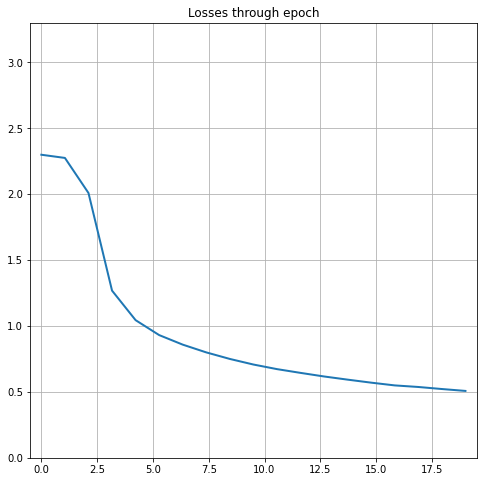

In [28]:
import matplotlib.pyplot as plt
import numpy as np



x = np.linspace(0, len(main_losses), len(main_losses))
y = main_losses

plt.figure(figsize=(8,8))
plt.plot(x, y, linewidth=2.0)
plt.ylim(0, max(main_losses) + 1)
plt.xlim(-0.5, len(main_losses) + 0.5)
plt.title('Losses through epoch')
plt.grid()
plt.show()



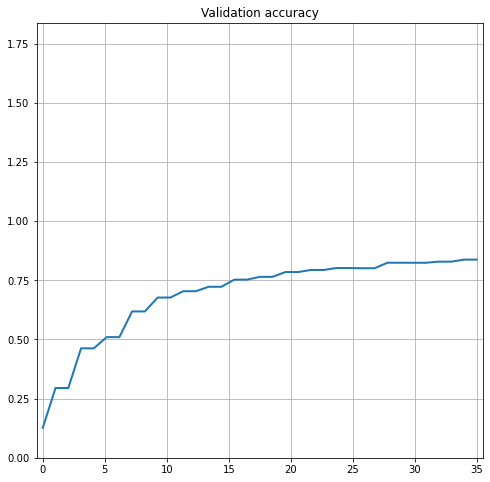

In [29]:
x = np.linspace(0, len(main_val_acc), len(main_val_acc))
y = main_val_acc

plt.figure(figsize=(8,8))
plt.plot(x, y, linewidth=2.0)
plt.ylim(0, max(main_val_acc) + 1)
plt.xlim(-0.5, len(main_val_acc) + 0.5)
plt.title('Validation accuracy')
plt.grid()
plt.show()

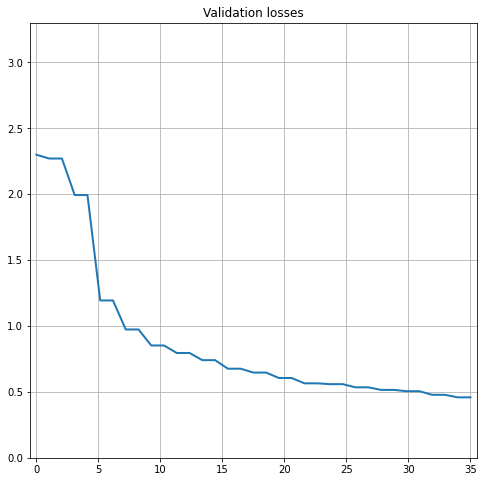

In [31]:
x = np.linspace(0, len(main_val_loss), len(main_val_loss))
y = main_val_loss

plt.figure(figsize=(8,8))
plt.plot(x, y, linewidth=2.0)
plt.ylim(0, max(main_val_loss) + 1)
plt.xlim(-0.5, len(main_val_loss) + 0.5)
plt.title('Validation losses')
plt.grid()
plt.show()